<a href="https://colab.research.google.com/github/rizwan09/ANCE/blob/master/Solution_of_Fall2020_CS146_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and titanic_train.csv
import sys

### ========== TODO : START ========== ###

sys.path += ['/content/drive/My Drive/Fall2020-CS146-HW1'] 

### ========== TODO : END ========== ###


In [4]:
from nutil import *

In [13]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [8]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        p = Counter(y)
        prob = [1.*x/len(y) for x in list(p.values())]
        self.probabilities_ =  [prob[0],prob[1]]

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)

        n,d = X.shape
        y = np.random.choice ([0,1], size = n, replace = True, p = self.probabilities_)

        ### ========== TODO : END ========== ###

        return y


In [9]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [14]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error over ntrials
    # hint: use train_test_split (be careful of the parameters)
    
    train_error = 0
    test_error = 0

    train_scores = []; test_scores = [];
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    sss.get_n_splits(X, y)
    # for i in range(ntrials):
    f1_scores = []; precision_scores = []; recall_scores = []
    for train_index, test_index in sss.split(X, y):
        # xtrain, xtest, ytrain, ytest = train_test_split (X,y, test_size = test_size, random_state = i)
        xtrain, xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        clf.fit (xtrain, ytrain)

        ypred = clf.predict (xtrain)
        err = 1 - metrics.accuracy_score (ytrain, ypred, normalize = True)
        train_scores.append (err)
        
        # f1 = metrics.f1_score(ytrain, ypred)
        # precision = f1 = metrics.precision_score(ytrain, ypred)
        # recall = metrics.recall_score(ytrain, ypred)
        # f1_scores.append(f1)
        # precision_scores.append(precision)
        # recall_scores.append(recall)


        ypred = clf.predict (xtest)
        err = 1 - metrics.accuracy_score (ytest, ypred, normalize = True)
        test_scores.append (err)

        f1 = metrics.f1_score(ytest, ypred, average='micro')
        # precision =  metrics.precision_score(ytest, ypred)
        # recall = metrics.recall_score(ytest, ypred)
        f1_scores.append(f1)
        # precision_scores.append(precision)
        # recall_scores.append(recall)

    train_error =  np.mean (train_scores)
    test_error = np.mean (test_scores)
    f1_score = np.mean(f1_scores)
    return train_error, test_error, f1_score
    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [11]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...
StandardScaler(copy=True, with_mean=True, with_std=True)
Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.615
Classifying using Decision Tree...
	-- training error: 0.000
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- training error: 0.195
	-- training error: 0.195
Investigating various classifiers...
	Majority Vote	-- avg train error : 0.240	avg test error : 0.240 	avg test F1: 0.760
	Random	-- avg train error : 0.432	avg test error : 0.442	avg test F1: 0.558
	Decision Tree	-- avg train error : 0.000	avg test error : 0.205	avg test F1: 0.795
	k-Nearest Neighbors	-- avg train error : 0.202	avg test error : 0.259	avg F1: 0.741
Finding the best k...
0.698,0.7230000000000001,0.7459999999999999,0.756,0.7529999999999999,0.757,0.7619999999999999,0.7629999999999999,0.7619999999999999,0.7609999999999999,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76
	best k: 15
Investig

<Figure size 432x288 with 0 Axes>

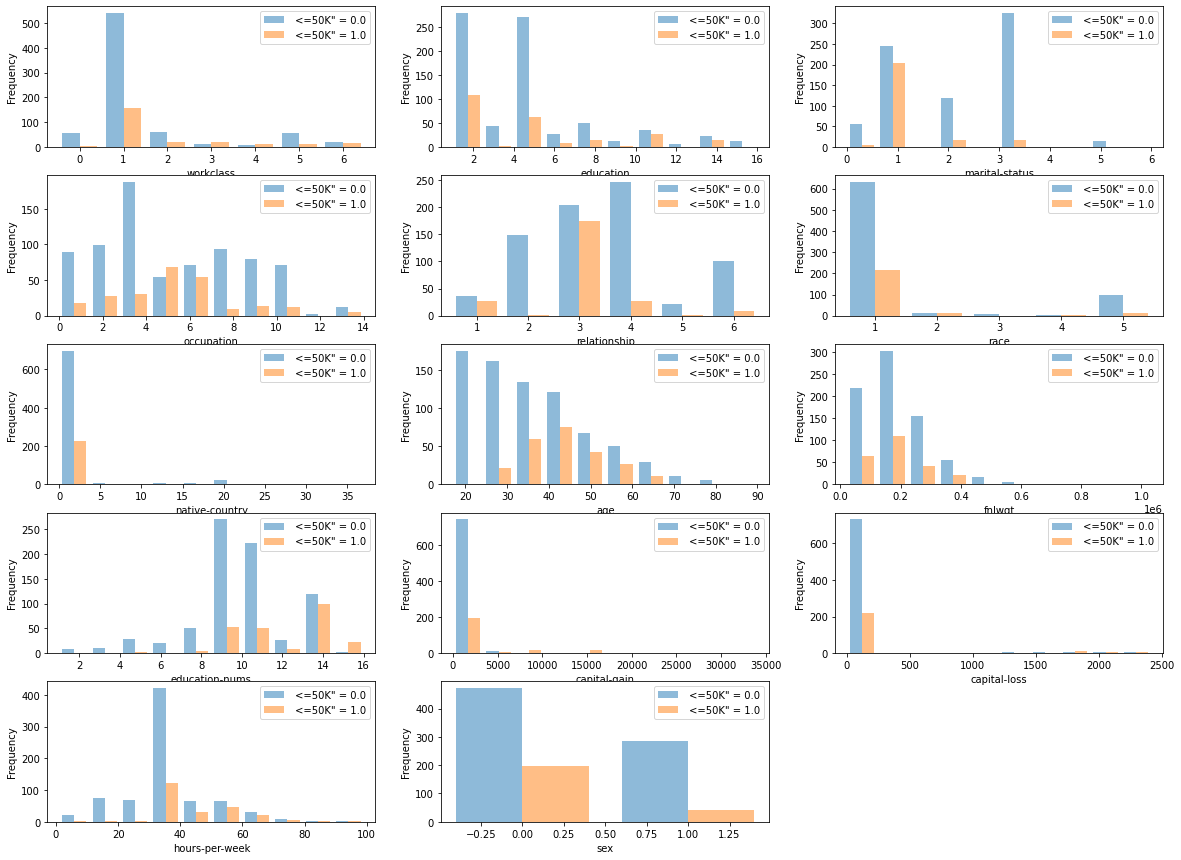

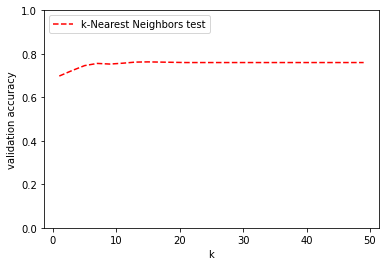

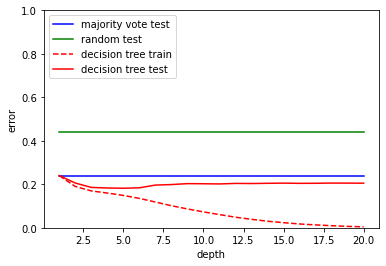

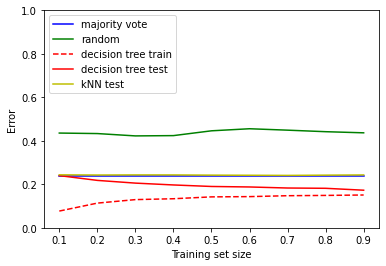

In [15]:

######################################################################
# main
######################################################################

def main():
    # load Titanic dataset with correct file path
    ### ========== TODO : START ========== ###
    titanic_file =  "/content/drive/My Drive/Fall2020-CS146-HW1/adult_subsample.csv"
    ### ========== TODO : END ========== ###
    
    titanic = load_data(titanic_file, header=1, predict_col=-1)

    X = titanic.X; Xnames = titanic.Xnames
    y = titanic.y; yname = titanic.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    

    plt.figure()
    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    

    ### ========== TODO : START ========== ###
    # Preprocess X (e.g., normalize)
    scaler = StandardScaler()
    print(scaler.fit(X))
    X = scaler.transform(X)
    ### ========== TODO : END ========== ###

    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)



    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    clf = RandomClassifier ()
    clf.fit (X,y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    clf = DecisionTreeClassifier (criterion = "entropy")
    clf.fit (X,y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    train_error = 1 - clf.fit (X,y).score(X, y)
    print('\t-- training error: %.3f' % train_error)

    ### ========== TODO : END ========== ###



    # note: uncomment out the following lines to output the Decision Tree graph
    """
    # save the classifier -- requires GraphViz and pydot
    import StringIO, pydotplus
    from sklearn import tree
    dot_data = StringIO.StringIO()
    tree.export_graphviz(clf, out_file=dot_data,
                         feature_names=Xnames)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_pdf("dtree.pdf")
    """



    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    clf = KNeighborsClassifier (n_neighbors = 5)
    clf.fit (X,y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    train_error = 1 - clf.fit (X,y).score(X, y)
    print('\t-- training error: %.3f' % train_error)

    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')
    train_error_mv, test_error_mv, f1_test = error (MajorityVoteClassifier(), X, y)
    print('\tMajority Vote\t-- avg train error : %.3f\tavg test error : %.3f \tavg test F1: %.3f' %(train_error_mv, test_error_mv,  f1_test))

    train_error_r, test_error_r, f1_test = error (RandomClassifier(), X, y)
    print('\tRandom\t-- avg train error : %.3f\tavg test error : %.3f\tavg test F1: %.3f' %(train_error_r, test_error_r, f1_test))

    train_error, test_error, f1_test = error (DecisionTreeClassifier (criterion = 'entropy'), X, y)
    print('\tDecision Tree\t-- avg train error : %.3f\tavg test error : %.3f\tavg test F1: %.3f' %(train_error, test_error,  f1_test))

    train_error, test_error, f1_test = error (KNeighborsClassifier (n_neighbors = 5), X, y)
    print('\tk-Nearest Neighbors\t-- avg train error : %.3f\tavg test error : %.3f\tavg F1: %.3f' %(train_error, test_error, f1_test))

    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    k = list(range(1,50,2))
    cv_score = []
    for i in k:
        score = cross_val_score(KNeighborsClassifier(n_neighbors = i), X, y, cv = 10, scoring='accuracy')
        cv_score.append(score.mean())

    xlim = (min(k), max(k))
    plt.figure ()
    plt.plot (k, cv_score, 'r--', label='k-Nearest Neighbors test')
    plt.xlabel('k')
    plt.ylabel('validation accuracy')
    plt.legend (loc='upper left')
    plt.ylim((0,1))
    plt.savefig ('accuracyvsk.pdf')

    acc = [str(a) for a in cv_score]
    print(',' .join(acc))

    ind = cv_score.index(max(cv_score))
    best_k = k [ind]
    print('\tbest k:' , best_k)

    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    depths = list(range(1,21))
    train_error = []; test_error = []
    for i in depths:
        tmp1, tmp2, f1_test = error (DecisionTreeClassifier (criterion = 'entropy', max_depth = i), X, y)
        train_error.append (tmp1)
        test_error.append (tmp2)

    sarr = [str(a) for a in test_error]
    print(',' .join(sarr))

    xlim = (min(depths), max(depths))
    plt.figure ()
    plt.plot (xlim, [test_error_mv]*2, 'b-', label='majority vote test')
    plt.plot (xlim, [test_error_r]*2, 'g-', label='random test')
    plt.plot (depths, train_error, 'r--', label='decision tree train')
    plt.plot (depths, test_error, 'r-', label='decision tree test')
    plt.xlabel('depth')
    plt.ylabel('error')
    plt.legend (loc='upper left')
    plt.ylim((0,1))
    plt.savefig ('errorvsdepth.pdf')

    ind = test_error.index(min(test_error))
    best_depth = depths [ind]
    print('\toptimal depth:' , best_depth)

    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    print('Investigating training set sizes...')
    train_splits = np.arange (0.1, 1, 0.1)

    train_error_mv = []; test_error_mv = [];
    train_error_r = []; test_error_r = [];
    train_error_dt = []; test_error_dt = [];
    train_error_knn = []; test_error_knn = [];

    for i in train_splits:
        train_error, test_error, f1_test = error (MajorityVoteClassifier(), X, y, test_size = 1 - i)
        train_error_mv.append (train_error); test_error_mv.append(test_error)

        train_error, test_error, f1_test = error (RandomClassifier(), X, y, test_size = 1 - i)
        train_error_r.append (train_error); test_error_r.append(test_error)

        train_error, test_error, f1_test = error (DecisionTreeClassifier(criterion = 'entropy', max_depth = best_depth), X, y, test_size = 1 - i)
        train_error_dt.append (train_error); test_error_dt.append(test_error)

        train_error, test_error, f1_test = error (KNeighborsClassifier(n_neighbors = best_k), X, y, test_size = 1 - i)
        train_error_knn.append (train_error); test_error_knn.append(test_error)

    plt.figure ()
    plt.plot (train_splits, test_error_mv, 'b-', label = 'majority vote')
    plt.plot (train_splits, test_error_r, 'g-', label = 'random')
    plt.plot (train_splits, train_error_dt, 'r--', label = 'decision tree train')
    plt.plot (train_splits, test_error_dt, 'r-', label = 'decision tree test')
    plt.plot (train_splits, test_error_knn, 'y-', label = 'kNN test')
    plt.ylim ((0,1))
    plt.legend (loc ='upper left')
    plt.xlabel ('Training set size')
    plt.ylabel ('Error')
    plt.savefig ('errorvssize.pdf')

    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
